* Import Libraries

In [147]:
import glob
import os

import random
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from tqdm import tqdm

## Mean/Std of Dataset

In [148]:
sum_r, sum_g, sum_b = 0.0, 0.0, 0.0
sum_sq_r, sum_sq_g, sum_sq_b = 0.0, 0.0, 0.0
total_pixels = 0
total_img = 0

dataset_dir = 'Dataset'

In [149]:
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        total_img += len(os.listdir(class_path))

Progress_bar = tqdm(total=total_img, desc="Processing Images", unit="img")
print(f"Total number of images: {total_img}")

Processing Images:   0%|          | 0/6840 [00:00<?, ?img/s]

Total number of images: 6840


In [150]:
for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load: {img_path}")
            Progress_bar.update(1)
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32)
        
        sum_r += np.sum(img[:, :, 0])
        sum_g += np.sum(img[:, :, 1])
        sum_b += np.sum(img[:, :, 2])
        
        sum_sq_r += np.sum(img[:, :, 0] ** 2)
        sum_sq_g += np.sum(img[:, :, 1] ** 2)
        sum_sq_b += np.sum(img[:, :, 2] ** 2)
        
        total_pixels += img.shape[0] * img.shape[1]
        Progress_bar.update(1)
        
Progress_bar.close()

Processing Images: 100%|██████████| 6840/6840 [03:53<00:00, 29.35img/s]


In [153]:
mean_r = sum_r / total_pixels
mean_g = sum_g / total_pixels
mean_b = sum_b / total_pixels

std_r = np.sqrt((sum_sq_r / total_pixels) - (mean_r ** 2))
std_g = np.sqrt((sum_sq_g / total_pixels) - (mean_g ** 2))
std_b = np.sqrt((sum_sq_b / total_pixels) - (mean_b ** 2))

mean = [mean_r / 255, mean_g / 255, mean_b / 255]
std = [std_r / 255, std_g / 255, std_b / 255]

dataset_mean = [round(float(i), 5) for i in mean]
dataset_std = [round(float(j), 5) for j in std]

print(f"Dataset Mean (RGB): {dataset_mean}")
print(f"Dataset Std (RGB): {dataset_std}")

Dataset Mean (RGB): [0.57119, 0.57445, 0.60537]
Dataset Std (RGB): [0.11762, 0.12342, 0.11999]


In [154]:
dataset_mean = [0.57119, 0.57445, 0.60537]
dataset_std = [0.11762, 0.12342, 0.11999]

## Transform

In [216]:
transform_Album = A.Compose(
    [   
        A.Resize(256, 256),
        # A.Affine(
        #     translate_percent=0.02,
        #     scale=(0.95, 1.05),
        #     rotate=(-5, 5),
        #     fill=128,
        #     p=0.3
        # ),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            fill=128,
            p=0.4
        ),
        # A.HueSaturationValue(
        #     hue_shift_limit=2,
        #     sat_shift_limit=3,
        #     val_shift_limit=3,
        #     p=0.2
        # ),
        A.RandomBrightnessContrast(
            brightness_limit=(0, 0.2),
            contrast_limit=0.1,
            p=0.3
        ),
        # A.RGBShift(
        #   r_shift_limit=5,
        #   g_shift_limit=5,
        #   b_shift_limit=5,
        #   p=0.2 
        # ),
        A.Blur(
            blur_limit=3,
            p=0.2
        ),
        # A.GaussNoise(
        #     std_range=(0.01, 0.02),
        #     mean_range=(0.04, 0.06),
        #     p=0.2
        # ),
        # A.CoarseDropout(
        #     num_holes_range=(1, 2),
        #     hole_height_range=(4, 6),
        #     hole_width_range=(4, 6),
        #     fill=128,
        #     p=0.2
        # ),
        A.Normalize(
            mean=dataset_mean,
            std=dataset_std,
            max_pixel_value=255.0
        ),
        ToTensorV2()
    ],
    p=1
)

In [233]:
transform_Simple = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ]
)

## Traffic Sign Dataset

In [283]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 256, 256)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [284]:
root_dir = "TestDB"
images_path_list = []
labels_path_list = []
class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

In [285]:
class_idx

{0: 'barred_area',
 1: 'cross_walk',
 2: 'go_straight',
 3: 'no_passing_zone_beginning',
 4: 'parking_zone',
 5: 'priority_over',
 6: 'steep_hill_downhill',
 7: 'steep_hill_uphill',
 8: 'stop',
 9: 'tunnel_beginning',
 10: 'turn_left',
 11: 'turn_right'}

In [286]:
trafficSign_train = TrafficSignDB(
    images_path_list=images_path_list,
    labels_path_list=labels_path_list,
    transform=transform_Simple
)

In [287]:
def sign_sample(dataset, index):
    image, label = dataset[index]
    class_name = dataset.get_class_name(label)
    
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose((1, 2, 0))
        
        # mean = np.array(dataset_mean)
        # std = np.array(dataset_std)
        
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        
        image = image * std + mean
        image = np.clip(image, 0, 1)
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(f"Class: {class_name}\nLabel: {label}")
    plt.axis('off')
    plt.show()

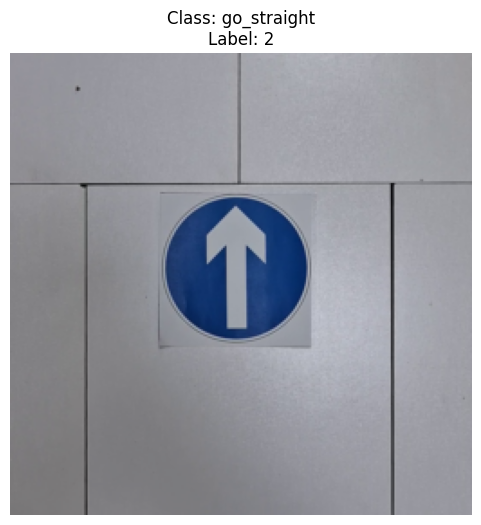

In [288]:
random_idx = random.randint(0, len(trafficSign_train)-1)
sign_sample(trafficSign_train, random_idx)

## Training the Model

In [297]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

In [298]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TrafficSignCNN, self).__init__()
        
        # self.model = models.resnet18(pretrained=True)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [299]:
train_loader = DataLoader(trafficSign_train, batch_size=32, shuffle=True, num_workers=0)

model = TrafficSignCNN(num_classes=12)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device=device)
print(f"Using device: {device}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


In [301]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        correct_pred += torch.sum(preds == labels).item()
        total_pred += labels.size(0)
        
        running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_pred / total_pred
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


torch.save(model.state_dict(), "traffic_sign_cnn.pth")

Epoch 1/10, Loss: 0.2082, Accuracy: 0.1250
Epoch 1/10, Loss: 0.3358, Accuracy: 0.0938
Epoch 1/10, Loss: 0.4574, Accuracy: 0.1250
Epoch 1/10, Loss: 0.5747, Accuracy: 0.1641
Epoch 1/10, Loss: 0.6851, Accuracy: 0.2250
Epoch 1/10, Loss: 0.7914, Accuracy: 0.2552
Epoch 1/10, Loss: 0.8939, Accuracy: 0.2634
Epoch 1/10, Loss: 0.9833, Accuracy: 0.2969
Epoch 1/10, Loss: 1.0558, Accuracy: 0.3333
Epoch 1/10, Loss: 1.1171, Accuracy: 0.3625
Epoch 1/10, Loss: 1.1702, Accuracy: 0.3864
Epoch 1/10, Loss: 1.1985, Accuracy: 0.4219
Epoch 1/10, Loss: 1.2412, Accuracy: 0.4423
Epoch 1/10, Loss: 1.2593, Accuracy: 0.4732
Epoch 1/10, Loss: 1.2727, Accuracy: 0.5000
Epoch 1/10, Loss: 1.3203, Accuracy: 0.5117
Epoch 1/10, Loss: 1.3358, Accuracy: 0.5312
Epoch 1/10, Loss: 1.3638, Accuracy: 0.5451
Epoch 1/10, Loss: 1.3922, Accuracy: 0.5592
Epoch 1/10, Loss: 1.4179, Accuracy: 0.5719
Epoch 1/10, Loss: 1.4286, Accuracy: 0.5785
Epoch 2/10, Loss: 0.0067, Accuracy: 1.0000
Epoch 2/10, Loss: 0.0224, Accuracy: 0.9375
Epoch 2/10,